# Graph Neural Network
---
> Graph neural network model for vertex dynamics and tension prediction

- Seeding RNG [Pytorch reproducibility ](https://pytorch.org/docs/stable/notes/randomness.html)

**To-Do**👷🚧
- need a func-n w/ a **rollout error**,
- convert vel-y error to **position error**
- *Training loop*:
    - [ ] Combine `Message` and `AggregateUpdate` into a graph layer `GraphBlock`
- [ ] Write *prediction stage*: read \{test, val, train\} data and predict w/ saving. 1-step and rollout error measurements.
- [ ] Run more simul-s. Save them as both 1-frame and rollout datasets (in rollout dataset keep each movie as a seperate dataset).
- [ ] Experiments (**save all models** w/ backups; will need to test on the real tensions)<br>
*Params*: edge attrib-s, cell layer, arch(skip con-s), input noise (for long term prediction). *Errors*: 1-step, and rollout error (check after training at test time).
    1. Experiment with GN arch-s w/ *residual* (w/ skip) and *non-residual* architectures.
    1. Find a *rough number of layers* (Mess. passing steps) and hidden *dim-s sizes* for var-s. --> Initial estimates for next experiments.
    1. *Edge directions experiment*: train w/ and w/o edge dir-s, do edge dir-s help to speed up training?
    1. *Cell layer*: does having dedicated cell processing layer help to increase the accuracy?
    1. For best (resnet or non-resnet) run *number of layers and dim-n sizes*. Try deep nets, how does accuracy change with increasing the depth of the net?
    1. If resnet is better: try w/and w/o edge dir-s and "cell layers".
    1. Number of previous velocities (window size).
    1. Rollout experiment 1— *input noise*: according to Sanchez-Gonzalez, *et al.* \[ASG2020\], Brownian noise improves rollout accuracies (long term accuracy of the whole movie, and/or prediction stability/robustness).
    1. Rollout experiment 2— *rollout training*: train directly on rollout, i.e. use 5- and 10-step loss instead of a 1-step loss for training (slower training).
    1. Optional:
        - compare MLP vs CONV layers for message passing.
        - try with dynamic graphs (construct graphs on the fly based on relative positions, and use cell edges and cell attrib only for queries on `Y_edge`, `Y_cell`).
- [ ] Ablation dataset (*real*).

---
**DOING**🛠
1. Construct graph net without skip connections.
1. Combine Message and AggregateUpdate into a graph layer GraphNet (GN) block, a more general block, that can be composed into a deep residual network. "AddGN" block, w/ `AddGN(x) = f(x)+x` form (in fact, where it's possible make all blocks with this form.
1. Construct residual net out of GNs.
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [3]:
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies
from simgnn.train import train_model, write_log, load_log
from simgnn.nn import Plain_MLP, Single_MP_step, mlp, Message, AggregateUpdate, Aggregate
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure, Reshape_x
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Training

- Normalise real--Hara movies and ablation,  and simulated movies. Use same normalisation constants for all simulated movies.
- Hara movies and ablation movies have different normalisation constants due to different time and spatial resolution. (Can convert to  microns and use same `l_av` for both.)

|Dataset | Details | Shortname| Avg. edge len.| Transforms (Normalisation)|
|:---:|:---|:---|---:|:---|
|Synthetic datasets     | vertex dynamics simulations| "train" and "val"| 0.857 a.u.| `[Pos2Vec(scale=10*0.857)`, `ScaleVelocity(0.5*0.857)`, `ScaleTension(5,shift=1.45)`, `ScalePressure(3, shift=1.0)]`|
|Hara movies dataset    | no force information       | "hara"| 26.32 pixels|`[Pos2Vec(scale=10*26.32)`,`ScaleVelocity(0.5*26.32)]`|
|(Hara) ablation dataset| short movies w/ recoil data| "abln"| ? | ? |


### Datasets

`CellData` prop-s (graph data objects):
- `x` : `(#nodes, WindowWidth, 2)` *node features*
- `y` : `(#nodes, 2)` *node targets (velocities)*.
- `pos` : `(#nodes, 2)` *node positions*.
- `edge_attr` : `(#edges, 2)` or `(#edges, #edge_features)` *edge features  (relative Cartesian positions of connected nodes)*.
- `edge_index` : `(2, #edges)` *edge indices*.
- `edge_tensions` : `(#edges,)` *edge targets (line tensions)*.
- `node2cell_index` : `(2, #cell2node_edges)`, `node2cell`-> *first row is node indices and second row is cell indices;
- `cell2node_index` : `(2, #cell2node_edges)`, `cell2node`-> *first row is cell indices and second row is node indices*.
- `cell_pressures` : `(#cells,)` *cell targets (cell pressures)*.

In [117]:
window_size = 5

# Normalisation: for simulated data (simul params ~ normal distr-s): l0=1.0, Hara_movie: l0=26.32
Tnorm = T.Compose([Pos2Vec(scale=1.0*10.0) , ScaleVelocity(1.0*0.5),
                   ScaleTension(0.634, shift=0.6), ScalePressure(0.33, shift=0.1 ), Reshape_x((-1,window_size*2)) ] )

Tnorm_hara = T.Compose([Pos2Vec(scale=10*26.32) , ScaleVelocity(0.5*26.32), Reshape_x((-1,window_size*2))]) # Hara movie dataset norm

# Datasets
train1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size, transform=Tnorm)
train2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size, transform=Tnorm)

datasets_dict = {'train': train1+train2,
                'sim'   : VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/',  window_size=window_size, transform=Tnorm),
                'hara'  : HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorm_hara)}
#                 'sim2' : VertexDynamics('./simgnn_data/expmodulation_sims/val/',  window_size=window_size, transform=Tnorm)}

# datasets_dict['early'] = datasets_dict['hara'][:len(datasets_dict['hara'])//3]
# datasets_dict['mid'] = datasets_dict['hara'][len(datasets_dict['hara'])//3*2:]
# datasets_dict['late'] = datasets_dict['hara'][len(datasets_dict['hara'])//3:len(datasets_dict['hara'])//3*2]

train : <torch.utils.data.dataset.ConcatDataset object at 0x7fd1215be130>

Frame 1:
CellData(cell2node_index=[2, 480], cell_pressures=[80], edge_attr=[275, 2], edge_index=[2, 275], edge_tensions=[275], node2cell_index=[2, 480], pos=[196, 2], x=[196, 10], y=[196, 2])


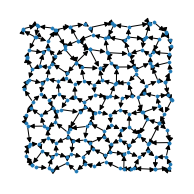

In [118]:
k='train'
print('{} : {}\n\nFrame 1:\n{}'.format(k,datasets_dict[k],datasets_dict[k][0]))
plt.figure(figsize=[2.5,2.5])
nx.draw(to_networkx(datasets_dict[k][0]),pos=dict(enumerate(datasets_dict[k][0].pos.numpy())), node_size=10)

#### Persistence Loss

In [119]:
for k in datasets_dict:
    print(f'Persistence {k}: {persistence_loss(datasets_dict[k])}')

Persistence train: {'mae': 0.06815911, 'mse': 0.009088826}
Persistence sim: {'mae': 0.06426177, 'mse': 0.007703601}
Persistence hara: {'mae': 0.041335844, 'mse': 0.004116387}


In [104]:
# datasets_dict['hara'].processed_file_names[len(datasets_dict['hara'])//3:len(datasets_dict['hara'])//3*2]

### Experiments

#### Plain MLP
> y=MLP(x) models (no graph), uses single node trends to predict trajectory

- Train on 5 movies from same sim param distrib.
    - Best MLP model for `window_size=5`: `net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=[16,8,8,8,4],dropout_p=dropout_p)`
- Using 5+5 movies from two different sim param distrib-s
    - Needs more complex model.

In [205]:
torch.manual_seed(0)

dropout_p = 0.2

net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=[32,16,16,16,8,8],dropout_p=dropout_p).to(device)

num_epochs = 30
lr = 0.03
bs = 32
loss_func = torch.nn.MSELoss(reduction='mean')
# loss_func = torch.nn.L1Loss(reduction='mean')
# opt = torch.optim.Adam(net.parameters(), lr=lr)
opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

return_best = True

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs,follow_batch=['cell_pressures','edge_index'], shuffle=True),
           'val': DataLoader(datasets_dict['hara'], batch_size=bs),
           'sim': DataLoader(datasets_dict['sim'], batch_size=bs,follow_batch=['cell_pressures','edge_index'])}
#            'early': DataLoader(datasets_dict['early'], batch_size=bs),
#            'mid': DataLoader(datasets_dict['mid'], batch_size=bs),
#            'late': DataLoader(datasets_dict['late'], batch_size=bs)
#           }
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {k:[False,False] for k in loaders}

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{net.__class__.__name__}_dp{dropout_p}bs{bs}w{window_size}{"best" if return_best else ""}'
save_dir = './simgnn_data/saved_models/'

Training param-s: #epochs=30, metric=MSELoss(), batch_size=32, optim=SGD, sch-r=none, return_best=False
---
Epoch 0/29: train_loss_tot=0.0260; train_loss_y=0.0260; |val_loss_tot=0.0060; val_loss_y=0.0060; |sim_loss_tot=0.0096; sim_loss_y=0.0096; |4s
Epoch 1/29: train_loss_tot=0.0126; train_loss_y=0.0126; |val_loss_tot=0.0047; val_loss_y=0.0047; |sim_loss_tot=0.0081; sim_loss_y=0.0081; |9s
Epoch 2/29: train_loss_tot=0.0109; train_loss_y=0.0109; |val_loss_tot=0.0041; val_loss_y=0.0041; |sim_loss_tot=0.0078; sim_loss_y=0.0078; |13s
Epoch 3/29: train_loss_tot=0.0102; train_loss_y=0.0102; |val_loss_tot=0.0041; val_loss_y=0.0041; |sim_loss_tot=0.0077; sim_loss_y=0.0077; |17s
Epoch 4/29: train_loss_tot=0.0099; train_loss_y=0.0099; |val_loss_tot=0.0041; val_loss_y=0.0041; |sim_loss_tot=0.0077; sim_loss_y=0.0077; |22s
Epoch 5/29: train_loss_tot=0.0097; train_loss_y=0.0097; |val_loss_tot=0.0041; val_loss_y=0.0041; |sim_loss_tot=0.0077; sim_loss_y=0.0077; |27s
Epoch 6/29: train_loss_tot=0.0096; t

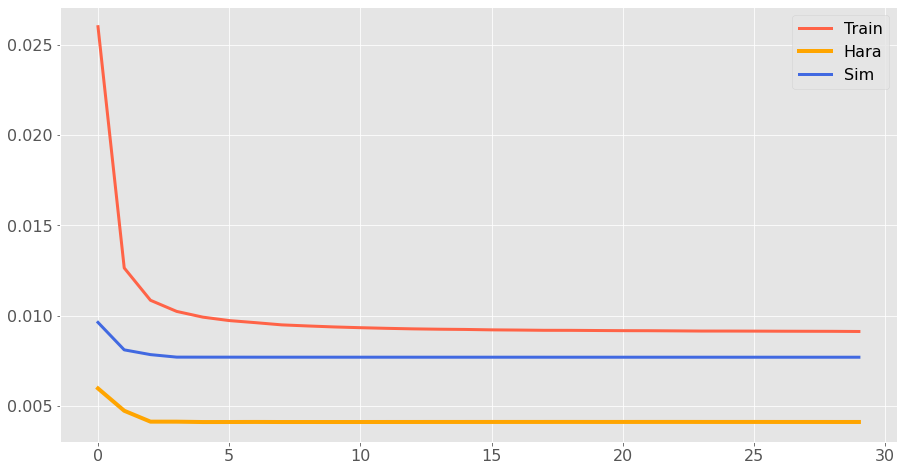

In [206]:
net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=None, device=device, model_states = model_states,
                               loss_func = loss_func, use_force_loss=use_force_loss,
                               return_best=False)
plt.figure(figsize=[15,8])
plt.plot(np.arange(train_log['total_epochs']),train_log['train_loss_tot'],'tomato',lw=3,label='Train')
plt.plot(np.arange(train_log['total_epochs']),train_log['val_loss_tot'],'orange',lw=4,label='Hara')
plt.plot(np.arange(train_log['total_epochs']),train_log['sim_loss_tot'],'royalblue',lw=3,label='Sim')
if 'sim2_loss_tot' in train_log:
    plt.plot(np.arange(train_log['total_epochs']),train_log['sim2_loss_tot'],'indigo',lw=2,label='Sim2')
plt.legend();

# write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
# torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')
# print(f'Model weights saved in \n{path.join(save_dir, model_name)}_net.pkl')

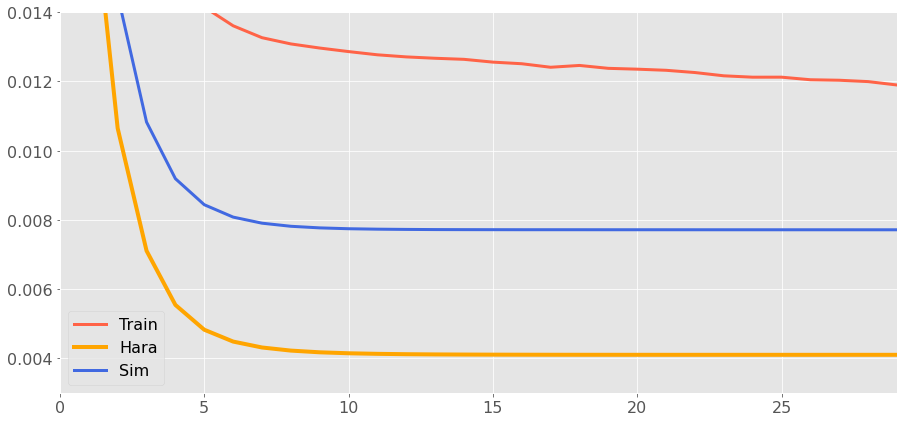

In [201]:
plt.figure(figsize=[15,7])
plt.plot(np.arange(train_log['total_epochs']),train_log['train_loss_tot'],'tomato',lw=3,label='Train')
plt.plot(np.arange(train_log['total_epochs']),train_log['val_loss_tot'],'orange',lw=4,label='Hara')
plt.plot(np.arange(train_log['total_epochs']),train_log['sim_loss_tot'],'royalblue',lw=3,label='Sim')
if 'sim2_loss_tot' in train_log:
    plt.plot(np.arange(train_log['total_epochs']),train_log['sim2_loss_tot'],'indigo',lw=2,label='Sim2')
plt.legend();
plt.axis([0,train_log['total_epochs']-1,0.003,0.014]);

In [165]:
# plt.figure(figsize=[35,10])
# ax1 = plt.subplot(1,4,1)
# ax1.plot(np.arange(train_log['total_epochs']),train_log['val_loss_y'],'orange',lw=4,label='Hara')
# ax1.hlines(0.0041163876,0,30)
# ax1.axis([0,30,0.00325,.0043]);
# ax1.legend();

# ax2 = plt.subplot(1,4,2,sharex=ax1,sharey=ax1)
# ax2.plot(np.arange(train_log['total_epochs']),train_log['early_loss_y'],'red',lw=4,label='Early',alpha=.7)
# ax2.hlines(0.0042118663,0,30)
# ax2.legend();

# ax3 = plt.subplot(1,4,3,sharex=ax1,sharey=ax1)
# ax3.plot(np.arange(train_log['total_epochs']),train_log['mid_loss_y'],'purple',lw=4,label='Middle',alpha=.7)
# ax3.hlines(0.00330922,0,30)
# ax3.legend();


# ax4 = plt.subplot(1,4,4,sharex=ax1)
# ax4.plot(np.arange(train_log['total_epochs']),train_log['late_loss_y'],'lime',lw=4,label='Late',alpha=.7)
# ax4.hlines(0.004734805,0,30)
# ax4.axis([0,30,0.004,.0048]);
# ax4.legend();

In [93]:
# plt.figure(figsize=[15,8])
# plt.plot(np.arange(train_log['total_epochs']),train_log['sim_loss_tot'],'royalblue',lw=3,label='Sim')
# plt.plot(np.arange(train_log['total_epochs']),train_log['val_loss_y'],'orange',lw=4,label='Hara')
# plt.plot(np.arange(train_log['total_epochs']),train_log['early_loss_y'],'red',lw=3,label='Early',alpha=.7)
# plt.plot(np.arange(train_log['total_epochs']),train_log['mid_loss_y'],'purple',lw=3,label='Middle',alpha=.7)
# plt.plot(np.arange(train_log['total_epochs']),train_log['late_loss_y'],'lime',lw=3,label='Late',alpha=.7)
# plt.legend();
# plt.axis([0,30,0,.009]);


---

#### Single Message Passing Step
> Single MP step, uses graph and relative node positions w.r.t. connected neighbouring nodes

- Single MP step w/ a very simple Update mlp. Update stage is equivalent to the node model (plain mlp) w/ an additional edge features as messages.

In [83]:
torch.manual_seed(0)

net = Single_MP_step(node_in_features=window_size*2, node_out_features=2, edge_in_features=2, message_out_features=5, message_hidden_dims=[10],aggr='max')

num_epochs = 30
lr = 0.001
bs = 8
MSE_loss = torch.nn.MSELoss(reduction='mean')
opt = torch.optim.Adam(net.parameters(), lr=lr)
# opt = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs,follow_batch=['cell_pressures','edge_index']),
          'val': DataLoader(datasets_dict['val'], batch_size=bs,follow_batch=['cell_pressures','edge_index']),
          'hara': DataLoader(datasets_dict['hara'], batch_size=bs)}
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {k:[False,False] for k in loaders}

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{net.__class__.__name__}_bs{bs}_w{datasets_dict["train"].window_size}'
save_dir = './simgnn_data/saved_models/'

Training param-s: #epochs=30, metric=MSELoss(), batch_size=8, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/29: train_loss_tot=0.0235; train_loss_y=0.0235; |val_loss_tot=0.0159; val_loss_y=0.0159; |hara_loss_tot=0.0139; hara_loss_y=0.0139; |2s
Epoch 1/29: train_loss_tot=0.0131; train_loss_y=0.0131; |val_loss_tot=0.0082; val_loss_y=0.0082; |hara_loss_tot=0.0074; hara_loss_y=0.0074; |4s
Epoch 2/29: train_loss_tot=0.0072; train_loss_y=0.0072; |val_loss_tot=0.0050; val_loss_y=0.0050; |hara_loss_tot=0.0049; hara_loss_y=0.0049; |7s
Epoch 3/29: train_loss_tot=0.0054; train_loss_y=0.0054; |val_loss_tot=0.0043; val_loss_y=0.0043; |hara_loss_tot=0.0048; hara_loss_y=0.0048; |9s
Epoch 4/29: train_loss_tot=0.0047; train_loss_y=0.0047; |val_loss_tot=0.0039; val_loss_y=0.0039; |hara_loss_tot=0.0051; hara_loss_y=0.0051; |11s
Epoch 5/29: train_loss_tot=0.0043; train_loss_y=0.0043; |val_loss_tot=0.0036; val_loss_y=0.0036; |hara_loss_tot=0.0052; hara_loss_y=0.0052; |13s
Epoch 6/29: train_loss_tot

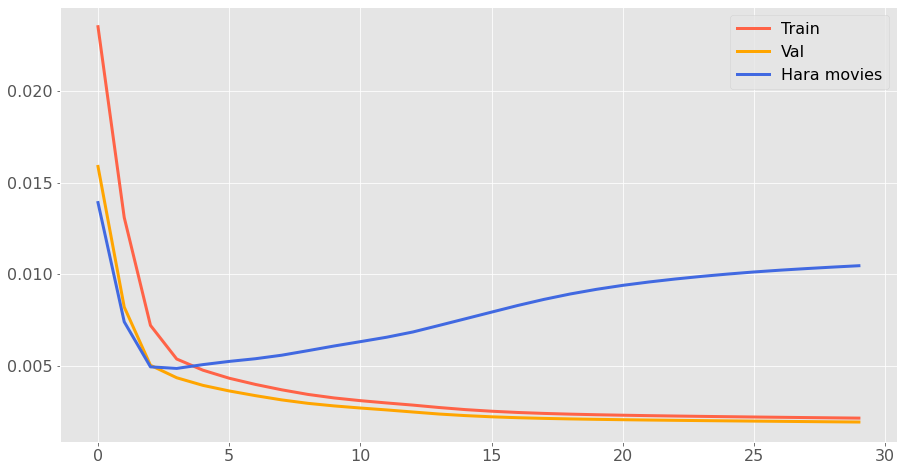

In [84]:
# ------- Train -------- #
net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=None, device=device, model_states = model_states,
                               loss_func = MSE_loss, use_force_loss=use_force_loss,
                               return_best=False)
plt.figure(figsize=[15,8])
plt.plot(np.arange(train_log['total_epochs']),train_log['train_loss_tot'],'tomato',lw=3,label='Train')
plt.plot(np.arange(train_log['total_epochs']),train_log['val_loss_tot'],'orange',lw=3,label='Val')
plt.plot(np.arange(train_log['total_epochs']),train_log['hara_loss_tot'],'royalblue',lw=3,label='Hara movies')
plt.legend();

write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')

- Single MP step w/ a larger Update mlp comparable to the plain mlp.

In [134]:
torch.manual_seed(0)

net = Single_MP_step(node_in_features=10, node_out_features=2, 
                     edge_in_features=2, message_out_features=8,
                     message_hidden_dims=[10,8], update_hidden_dims=[10,5])

num_epochs = 200
lr = 0.03
bs = 16
MSE_loss = torch.nn.MSELoss(reduction='mean')
opt = torch.optim.Adam(net.parameters(), lr=lr)
# opt = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs,follow_batch=['cell_pressures','edge_index']),
          'val': DataLoader(datasets_dict['val'], batch_size=bs,follow_batch=['cell_pressures','edge_index']),
          'hara': DataLoader(datasets_dict['hara'], batch_size=bs)}
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {k:[False,False] for k in loaders}

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M')+f'_{net.__class__.__name__}_bs{bs}_deepUpdate'
save_dir = './simgnn_data/saved_models/'

Training param-s: #epochs=200, metric=MSELoss(), batch_size=16, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/199: train_loss_tot=0.0388; train_loss_y=0.0388; |val_loss_tot=0.0095; val_loss_y=0.0095; |hara_loss_tot=0.0106; hara_loss_y=0.0106; |1s
Epoch 1/199: train_loss_tot=0.0061; train_loss_y=0.0061; |val_loss_tot=0.0080; val_loss_y=0.0080; |hara_loss_tot=0.0096; hara_loss_y=0.0096; |2s
Epoch 2/199: train_loss_tot=0.0042; train_loss_y=0.0042; |val_loss_tot=0.0035; val_loss_y=0.0035; |hara_loss_tot=0.0051; hara_loss_y=0.0051; |3s
Epoch 3/199: train_loss_tot=0.0033; train_loss_y=0.0033; |val_loss_tot=0.0025; val_loss_y=0.0025; |hara_loss_tot=0.0045; hara_loss_y=0.0045; |4s
Epoch 4/199: train_loss_tot=0.0022; train_loss_y=0.0022; |val_loss_tot=0.0026; val_loss_y=0.0026; |hara_loss_tot=0.0048; hara_loss_y=0.0048; |5s
Epoch 5/199: train_loss_tot=0.0018; train_loss_y=0.0018; |val_loss_tot=0.0025; val_loss_y=0.0025; |hara_loss_tot=0.0048; hara_loss_y=0.0048; |6s
Epoch 6/199: train_l

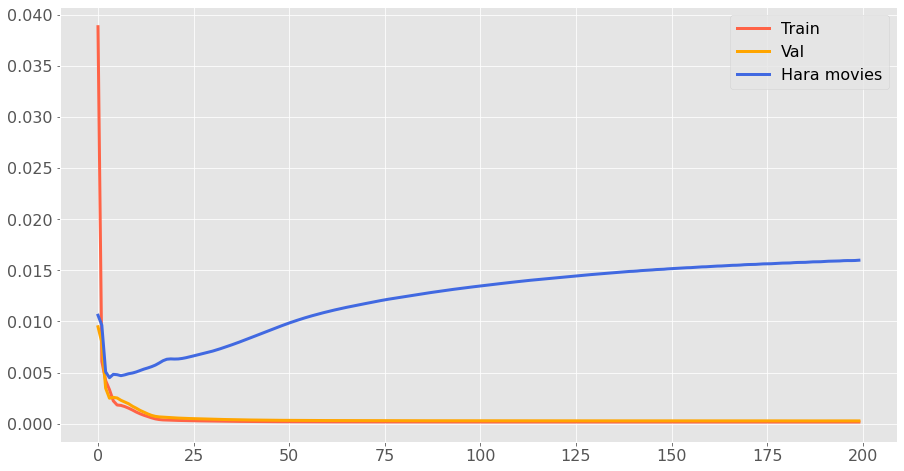

In [135]:
# ------- Train -------- #
net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=None, device=device, model_states = model_states,
                               loss_func = MSE_loss, use_force_loss=use_force_loss,
                               return_best=False)
plt.figure(figsize=[15,8])
plt.plot(np.arange(train_log['total_epochs']),train_log['train_loss_tot'],'tomato',lw=3,label='Train')
plt.plot(np.arange(train_log['total_epochs']),train_log['val_loss_tot'],'orange',lw=3,label='Val')
plt.plot(np.arange(train_log['total_epochs']),train_log['hara_loss_tot'],'royalblue',lw=3,label='Hara movies')
plt.legend();

# write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
# torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')

- **Examples**:
    - General "Message Passing" schemes: a nice example for composite graph layer –"meta layer" consisting of "edge", "node" and "global" layers [link](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer)

**Node-to-Cell Encoding/Pooling Layer**:
1. Initiate node-to-cell edge attr-s as (source) node attr-s `x[node2cell_index[0]]`.
1. Compute node-to-cell edge attr-s using MLP: `e_n2c = MLP( x[node2cell_index[0]] )`
1. Aggregate node-to-cell edge attr-s as cell attr-s : `x_cell = Aggregate(e_n2c)`
1. Compute new cell attr-s using (encodes `x_cell` into cell attr-s) : `h_cell = MLP_Cell_encoder( x_cell )`

```python
n2c_model = mlp(...) # "message", just node-wise MLP
cell_aggr = Aggregate()
cell_enc = mlp(...)

e_n2c = n2c_model(data.x)[data.node2cell_index[0]]
x_cell = cell_aggr(data.cell_pressures.size(0), data.node2cell_index, e_n2c)
h_cell = cell_enc(x_cell)
```

---
- **Adding noise from M steps**: Sum of M normal rand. var-s results in normal var. w/ variance M and s.t.d.=sqrt(M):
```python
x = np.random.normal(size=(5,1000))
y = x.sum(axis=0)
z = np.random.normal(size=(1,1000))*np.sqrt(5)
plt.hist(x.ravel(),bins=50,label='x',density=True)
plt.hist(y        ,bins=50,label='y',density=True)
plt.hist(z.ravel(),bins=50,label='z',density=True,alpha=.5)
plt.legend();
```